In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/home/jgauthie/om2/miniconda/envs/huggingface/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
suites = ["number_prep", "number_src", "number_orc",
          "reflexive_src_fem", "reflexive_src_masc",
          "reflexive_orc_fem", "reflexive_orc_masc",
          "reflexive_prep_fem", "reflexive_prep_masc",
          "subordination_src-src", "subordination_orc-orc", "subordination_pp-pp",
          "mvrr",
          "fgd_pp", "fgd_subject", "fgd_object"]

In [3]:
# Format: suite_first_token -> [((expected_grammatical_region, expected_grammatical_condition),
#                                (expected_ungrammatical_region, expected_ungrammatical_condition), ...]
# 
# Will be used to compute margins between region-condition values.

margin_measures = {
    "fgd_pp": [((8, "that_nogap"), (8, "what_nogap")),
               ((9, "what_gap"), (9, "that_gap"))],
    "fgd_subject": [((4, "that_nogap"), (4, "what_nogap")),
                    ((5, "what_gap"), (5, "that_gap"))],
    "fgd_object": [((6, "that_nogap"), (6, "what_nogap")),
                   ((7, "what_gap"), (7, "that_gap"))],
    
    "number_prep": [((7, "match_sing"), (7, "mismatch_sing")),
                    ((7, "match_plural"), (7, "mismatch_plural"))],
    "number_src": [((8, "match_sing"), (8, "mismatch_sing")),
                   ((8, "match_plural"), (8, "mismatch_plural"))],
    "number_orc": [((8, "match_sing"), (8, "mismatch_sing")),
                   ((8, "match_plural"), (8, "mismatch_plural"))],

    "reflexive_prep_fem": [((8, "match_sing"), (8, "mismatch_sing")),
                           ((8, "match_plural"), (8, "mismatch_plural"))],
    "reflexive_src_fem": [((9, "match_sing"), (9, "mismatch_sing")),
                          ((9, "match_plural"), (9, "mismatch_plural"))],
    "reflexive_orc_fem": [((9, "match_sing"), (9, "mismatch_sing")),
                          ((9, "match_plural"), (9, "mismatch_plural"))],
    "reflexive_prep_masc": [((8, "match_sing"), (8, "mismatch_sing")),
                            ((8, "match_plural"), (8, "mismatch_plural"))],
    "reflexive_src_masc": [((9, "match_sing"), (9, "mismatch_sing")),
                           ((9, "match_plural"), (9, "mismatch_plural"))],
    "reflexive_orc_masc": [((9, "match_sing"), (9, "mismatch_sing")),
                           ((9, "match_plural"), (9, "mismatch_plural"))],
    
    "subordination_src-src": [((6, "no-sub_no-matrix"), (6, "sub_no-matrix")),
                              ((6, "sub_matrix"), (6, "no-sub_matrix"))],
    "subordination_orc-orc": [((6, "no-sub_no-matrix"), (6, "sub_no-matrix")),
                              ((6, "sub_matrix"), (6, "no-sub_matrix"))],
    "subordination_pp-pp": [((6, "no-sub_no-matrix"), (6, "sub_no-matrix")),
                            ((6, "sub_matrix"), (6, "no-sub_matrix"))],
    
    "mvrr": [((6, "unreduced_ambig"), (6, "reduced_ambig")),
             ((6, "reduced_unambig"), (6, "reduced_ambig"))],
}

In [4]:
critical_regions = {suite: set(region for region_comparison in region_comparisons for region in region_comparison)
                    for suite, region_comparisons in margin_measures.items()}
critical_region_strs = {suite: {" ".join(map(str, region)) for region in regions} for suite, regions in critical_regions.items()}
critical_region_strs

{'fgd_pp': {'8 that_nogap', '8 what_nogap', '9 that_gap', '9 what_gap'},
 'fgd_subject': {'4 that_nogap', '4 what_nogap', '5 that_gap', '5 what_gap'},
 'fgd_object': {'6 that_nogap', '6 what_nogap', '7 that_gap', '7 what_gap'},
 'number_prep': {'7 match_plural',
  '7 match_sing',
  '7 mismatch_plural',
  '7 mismatch_sing'},
 'number_src': {'8 match_plural',
  '8 match_sing',
  '8 mismatch_plural',
  '8 mismatch_sing'},
 'number_orc': {'8 match_plural',
  '8 match_sing',
  '8 mismatch_plural',
  '8 mismatch_sing'},
 'reflexive_prep_fem': {'8 match_plural',
  '8 match_sing',
  '8 mismatch_plural',
  '8 mismatch_sing'},
 'reflexive_src_fem': {'9 match_plural',
  '9 match_sing',
  '9 mismatch_plural',
  '9 mismatch_sing'},
 'reflexive_orc_fem': {'9 match_plural',
  '9 match_sing',
  '9 mismatch_plural',
  '9 mismatch_sing'},
 'reflexive_prep_masc': {'8 match_plural',
  '8 match_sing',
  '8 mismatch_plural',
  '8 mismatch_sing'},
 'reflexive_src_masc': {'9 match_plural',
  '9 match_sing',
 

In [5]:
sns.set_context("talk")

## Prediction results

In [6]:
prediction_dfs = [pd.read_csv(f"{suite}.predictions.csv") for suite in suites]
prediction_df = pd.concat(prediction_dfs, names=["suite"], keys=suites)
prediction_df["first_item"] = prediction_df.used_item_numbers.str.split().str.get(0)

canonical_suite = {suite_name: next(can_suite for can_suite in critical_regions.keys()
                                    if can_suite in suite_name)
                   for suite_name in set(prediction_df.index.get_level_values("suite"))}

prediction_df["canonical_suite"] = prediction_df.index.get_level_values("suite").map(canonical_suite)
prediction_df["suite_category"] = prediction_df.canonical_suite.str.split("_").apply(lambda parts: "_".join(parts[:-1]) if len(parts) > 1 else parts[0])
prediction_df["critical_region"] = prediction_df.canonical_suite.map(critical_regions)

prediction_df["num_prefix_sentences"] = prediction_df.used_conditions.str.count(" ").fillna(0)
prediction_df["prefix_length_bin"] = pd.cut(prediction_df.prefix_length, 20).astype(str)

prediction_df

Unnamed: 0  item_number  prediction_0  prediction_1  \
suite                                                                   
number_prep 0            0.0            1          True          True   
            1            1.0            2          True         False   
            2            2.0            3         False         False   
            3            3.0            4          True         False   
            4            4.0            5         False          True   
...                      ...          ...           ...           ...   
fgd_object  2451         NaN         2452          True          True   
            2452         NaN         2453          True          True   
            2453         NaN         2454          True          True   
            2454         NaN         2455          True          True   
            2455         NaN         2456          True          True   

                                                  used_item_numbers  \
suite                                                                 
number_prep 0                                                     1   
            1                                                     2   
            2                                                     3   
            3                                                     4   
            4                                                     5   
...                                                             ...   
fgd_object  2451  5 10 13 5 4 13 21 6 15 1 7 10 9 17 12 23 20 4 ...   
            2452  7 8 22 6 1 21 18 23 1 12 15 19 5 17 6 20 4 10 ...   
            2453  2 16 15 2 22 10 4 24 4 8 19 7 13 20 18 15 23 7...   
            2454  20 15 21 8 4 18 17 20 11 23 19 15 12 13 10 13 ...   
            2455  10 18 13 13 17 1 6 11 16 21 15 7 22 24 18 10 1...   

                                                    used_conditions  \
suite                                                                 
number_prep 0                                                   NaN   
            1                                                   NaN   
            2                                                   NaN   
            3                                                   NaN   
            4                                                   NaN   
...                                                             ...   
fgd_object  2451  what_gap what_gap what_gap that_nogap what_gap...   
            2452  what_gap what_gap that_nogap that_nogap what_g...   
            2453  that_nogap what_gap that_nogap what_gap that_n...   
            2454  what_gap that_nogap that_nogap what_gap that_n...   
            2455  that_nogap what_gap that_nogap what_gap that_n...   

                  prefix_length prediction_2 first_item canonical_suite  \
suite                                                                     
number_prep 0                 0          NaN          1     number_prep   
            1                 0          NaN          2     number_prep   
            2                 0          NaN          3     number_prep   
            3                 0          NaN          4     number_prep   
            4                 0          NaN          5     number_prep   
...                         ...          ...        ...             ...   
fgd_object  2451            494          NaN          5      fgd_object   
            2452            502          NaN          7      fgd_object   
            2453            497          NaN          2      fgd_object   
            2454            501          NaN         20      fgd_object   
            2455            494          NaN         10      fgd_object   

                 suite_category  \
suite                             
number_prep 0            number   
            1            number   
            2            number   
            3            number   
            4            number   

In [7]:
# Store basic representation of first item of each suite
basic_suite_df = prediction_df[prediction_df.prefix_length == 0].groupby("canonical_suite").first()
basic_suite_df

Unnamed: 0  item_number  prediction_0  prediction_1  \
canonical_suite                                                              
fgd_object                    NaN            1          True          True   
fgd_pp                        NaN            1          True          True   
fgd_subject                   NaN            1          True          True   
mvrr                          0.0            1          True          True   
number_orc                    0.0            1          True          True   
number_prep                   0.0            1          True          True   
number_src                    0.0            1          True          True   
reflexive_orc_fem             0.0            1         False          True   
reflexive_orc_masc            0.0            1          True          True   
reflexive_prep_fem            0.0            1         False          True   
reflexive_prep_masc           0.0            1          True          True   
reflexive_src_fem             0.0            1         False          True   
reflexive_src_masc            0.0            1          True          True   
subordination_orc-orc         0.0            1          True          True   
subordination_pp-pp           0.0            1          True          True   
subordination_src-src         0.0            1          True          True   

                      used_item_numbers used_conditions  prefix_length  \
canonical_suite                                                          
fgd_object                            1            None              0   
fgd_pp                                1            None              0   
fgd_subject                           1            None              0   
mvrr                                  1            None              0   
number_orc                            1            None              0   
number_prep                           1            None              0   
number_src                            1            None              0   
reflexive_orc_fem                     1            None              0   
reflexive_orc_masc                    1            None              0   
reflexive_prep_fem                    1            None              0   
reflexive_prep_masc                   1            None              0   
reflexive_src_fem                     1            None              0   
reflexive_src_masc                    1            None              0   
subordination_orc-orc                 1            None              0   
subordination_pp-pp                   1            None              0   
subordination_src-src                 1            None              0   

                      prediction_2 first_item  suite_category  \
canonical_suite                                                 
fgd_object                    None          1             fgd   
fgd_pp                        None          1             fgd   
fgd_subject                   None          1             fgd   
mvrr                          True          1            mvrr   
number_orc                    None          1          number   
number_prep                   None          1          number   
number_src                    None          1          number   
reflexive_orc_fem             None          1   reflexive_orc   
reflexive_orc_masc            None          1   reflexive_orc   
reflexive_prep_fem            None          1  reflexive_prep   
reflexive_prep_masc           None          1  reflexive_prep   
reflexive_src_fem             None          1   reflexive_src   
reflexive_src_masc            None          1   reflexive_src   
subordination_orc-orc         None          1   subordination   
subordination_pp-pp           None          1   subordination   
subordination_src-src         None          1   subordination   

                                                         critical_region  \
canonical_suite                       

In [8]:
# Get baseline accuracy results.
prediction_df[prediction_df.used_conditions.isna()] \
    [[col for col in prediction_df if col.startswith("prediction_") or col == "canonical_suite"]] \
    .melt(id_vars=["canonical_suite"]).groupby(["canonical_suite", "variable"]).value.mean().dropna()

canonical_suite        variable    
fgd_object             prediction_0    1.000000
                       prediction_1    0.958333
fgd_pp                 prediction_0    0.916667
                       prediction_1    0.958333
fgd_subject            prediction_0    0.625000
                       prediction_1    0.875000
mvrr                   prediction_0    1.000000
                       prediction_1    0.892857
                       prediction_2    0.857143
number_orc             prediction_0    0.631579
                       prediction_1    0.473684
number_prep            prediction_0    0.789474
                       prediction_1    0.526316
number_src             prediction_0    0.842105
                       prediction_1    0.473684
reflexive_orc_fem      prediction_0    0.473684
                       prediction_1    1.000000
reflexive_orc_masc     prediction_0    0.842105
                       prediction_1    0.947368
reflexive_prep_fem     prediction_0    0.210526
    

<AxesSubplot:xlabel='prefix_length', ylabel='Count'>

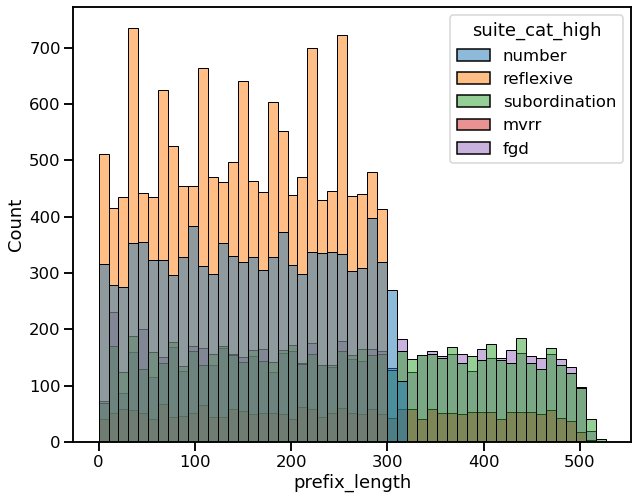

In [9]:
plt.subplots(figsize=(10, 8))
sns.histplot(data=prediction_df.assign(suite_cat_high=prediction_df.suite_category.str.split("_").str[0]), x="prefix_length", hue="suite_cat_high")

In [10]:
prediction_df_melt = prediction_df.reset_index()
meta_vars = ["num_prefix_sentences", "prefix_length", "prefix_length_bin", "canonical_suite", "suite_category", "item_number"]
prediction_df_melt = prediction_df_melt.loc[:, prediction_df_melt.columns.str.startswith(("prediction",) + tuple(meta_vars))] \
    .melt(id_vars=meta_vars, var_name="prediction", value_name="correct")
prediction_df_melt

num_prefix_sentences  prefix_length prefix_length_bin canonical_suite  \
0                        0.0              0   (-0.527, 26.35]     number_prep   
1                        0.0              0   (-0.527, 26.35]     number_prep   
2                        0.0              0   (-0.527, 26.35]     number_prep   
3                        0.0              0   (-0.527, 26.35]     number_prep   
4                        0.0              0   (-0.527, 26.35]     number_prep   
...                      ...            ...               ...             ...   
125599                  31.0            494   (474.3, 500.65]      fgd_object   
125600                  31.0            502   (500.65, 527.0]      fgd_object   
125601                  31.0            497   (474.3, 500.65]      fgd_object   
125602                  31.0            501   (500.65, 527.0]      fgd_object   
125603                  31.0            494   (474.3, 500.65]      fgd_object   

       suite_category  item_number    prediction correct  
0              number            1  prediction_0    True  
1              number            2  prediction_0    True  
2              number            3  prediction_0   False  
3              number            4  prediction_0    True  
4              number            5  prediction_0   False  
...               ...          ...           ...     ...  
125599            fgd         2452  prediction_2     NaN  
125600            fgd         2453  prediction_2     NaN  
125601            fgd         2454  prediction_2     NaN  
125602            fgd         2455  prediction_2     NaN  
125603            fgd         2456  prediction_2     NaN  

[125604 rows x 8 columns]

Text(1873.3439052734377, 0.5, 'Prediction accuracy')

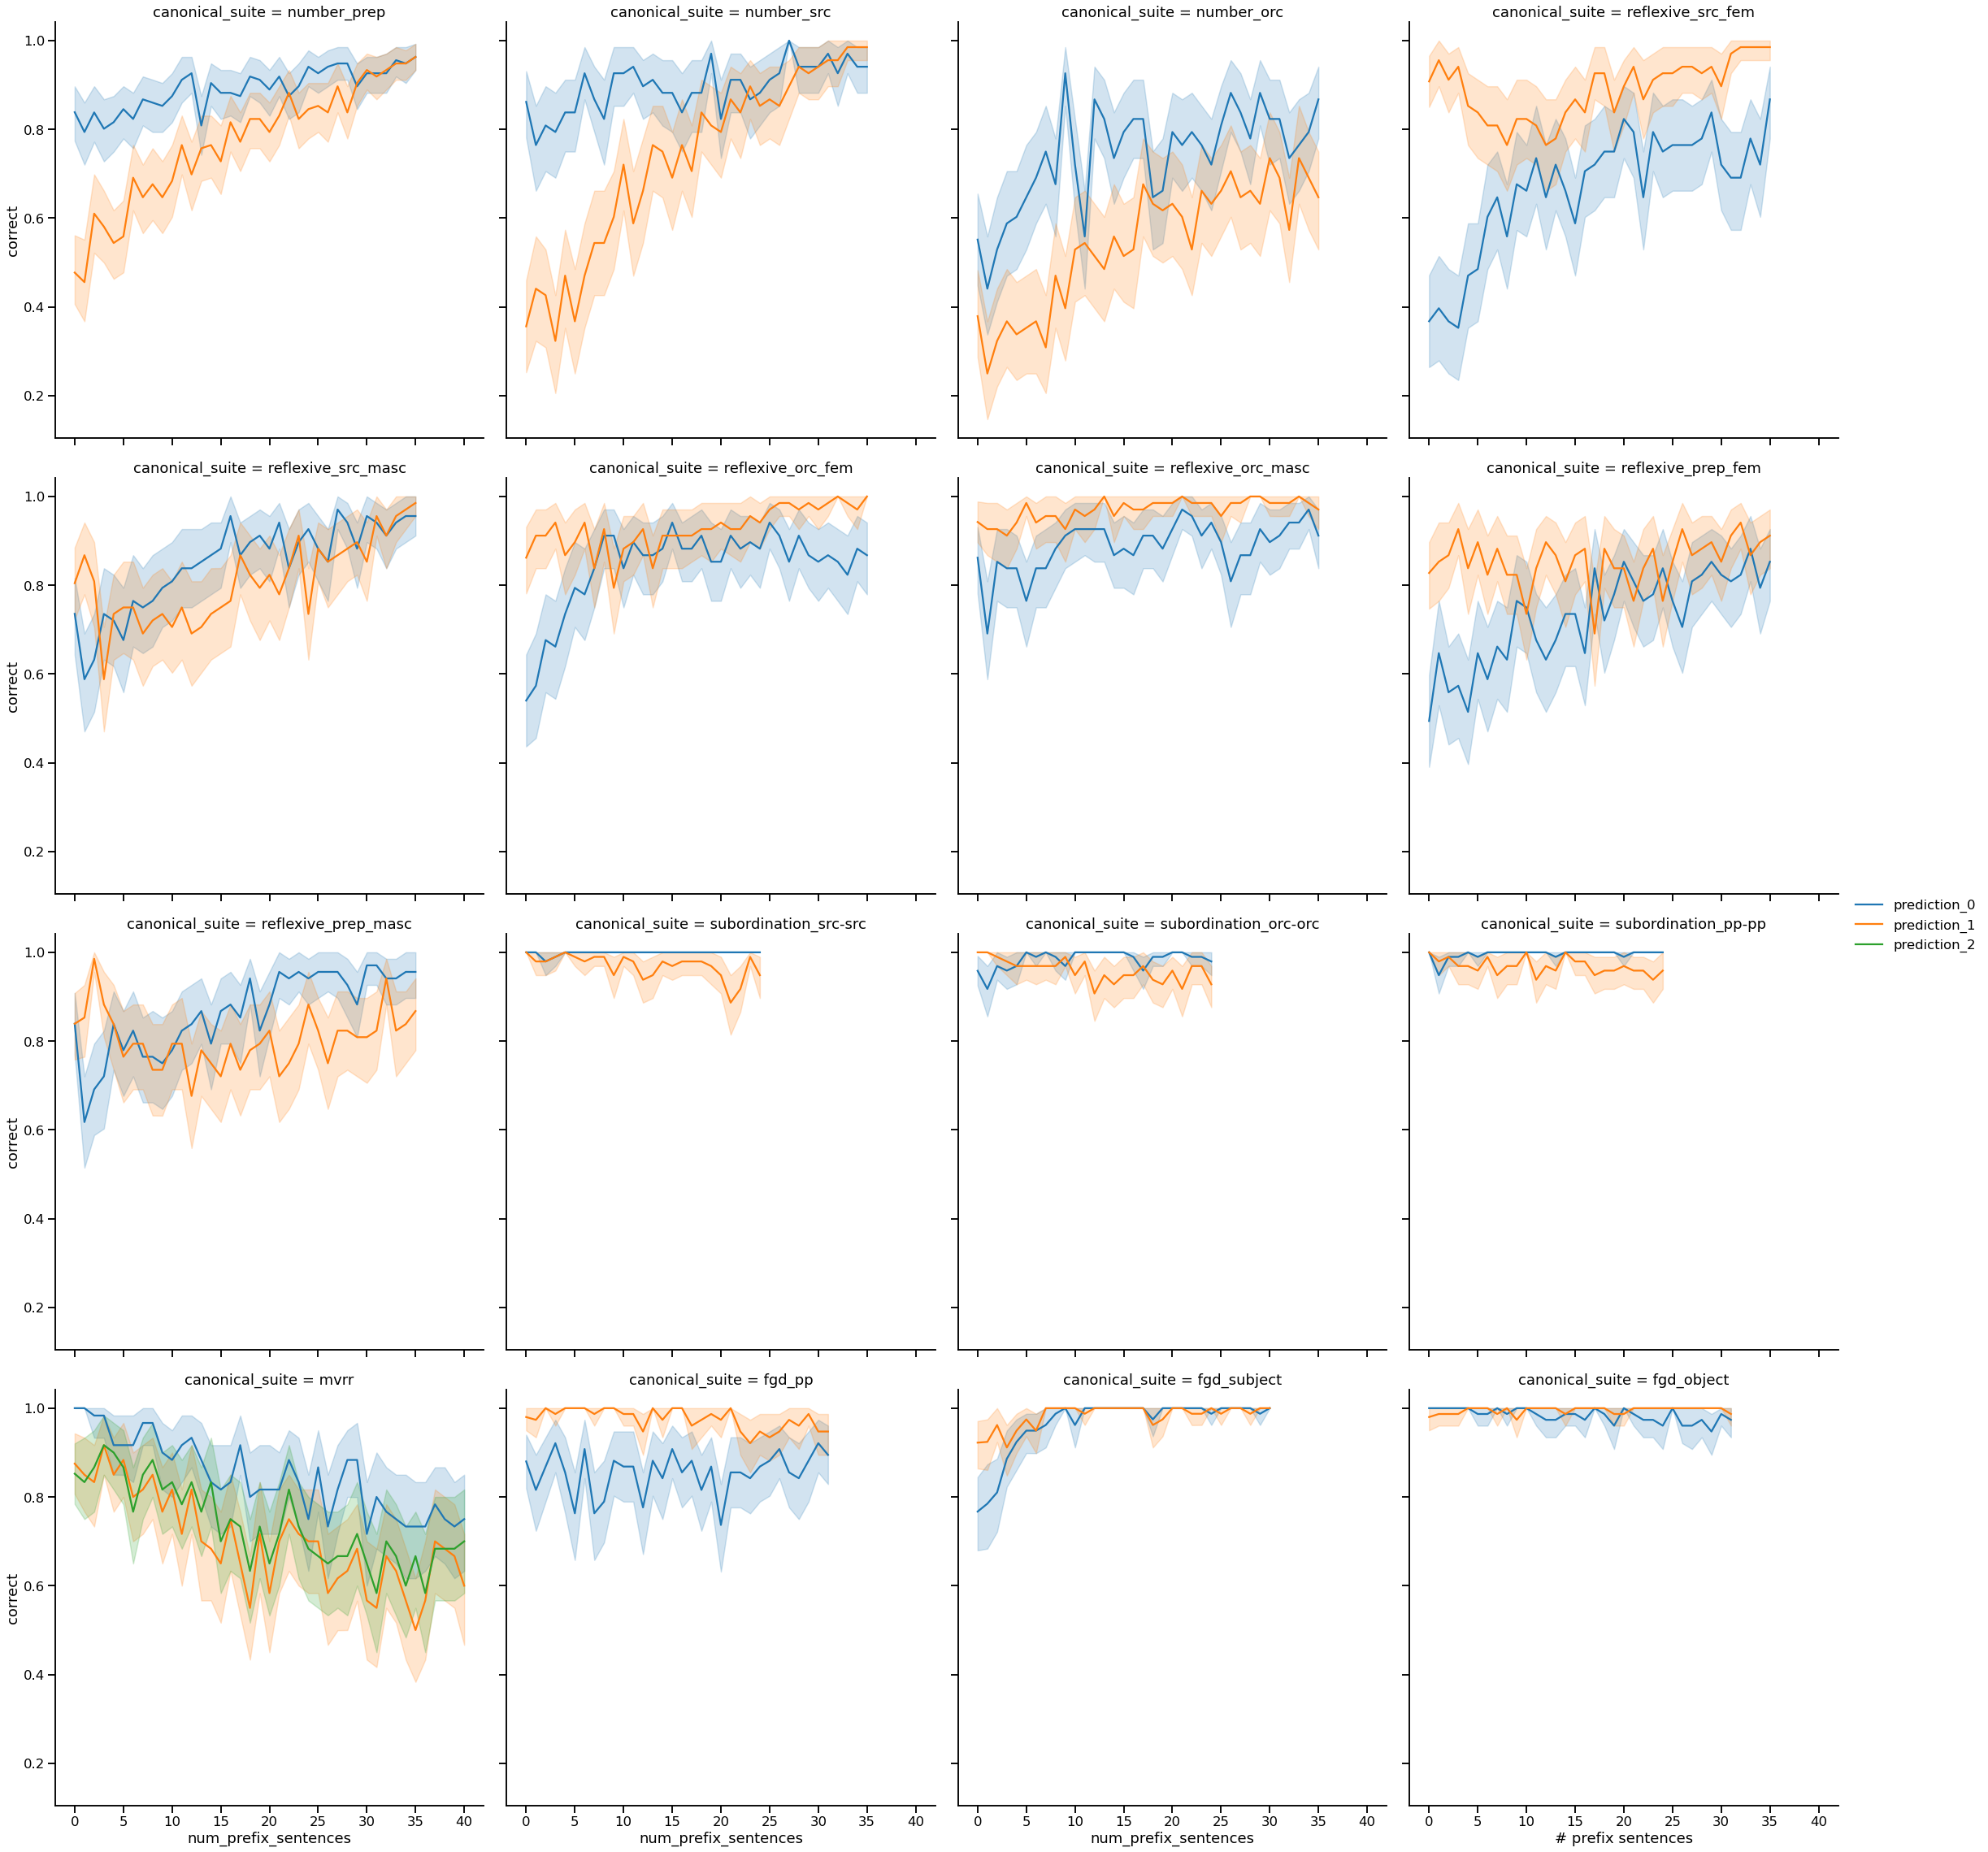

In [11]:
# TODO check conjunction of predictions

g = sns.FacetGrid(data=prediction_df_melt, height=8, col="canonical_suite", col_wrap=4)
g.map(sns.lineplot, "num_prefix_sentences", "correct", "prediction")
g.add_legend()

plt.xlabel("# prefix sentences")
plt.ylabel("Prediction accuracy")

In [12]:
# Too noisy. Use binned plot instead.
# sns.lineplot(data=prediction_df, x="prefix_length", y="prediction_0")

# plt.xlabel("# prefix tokens")
# plt.ylabel("Prediction accuracy")

/tmp/ipykernel_49048/2020521817.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right")


Text(1897.5401097375122, 0.5, 'Prediction accuracy')

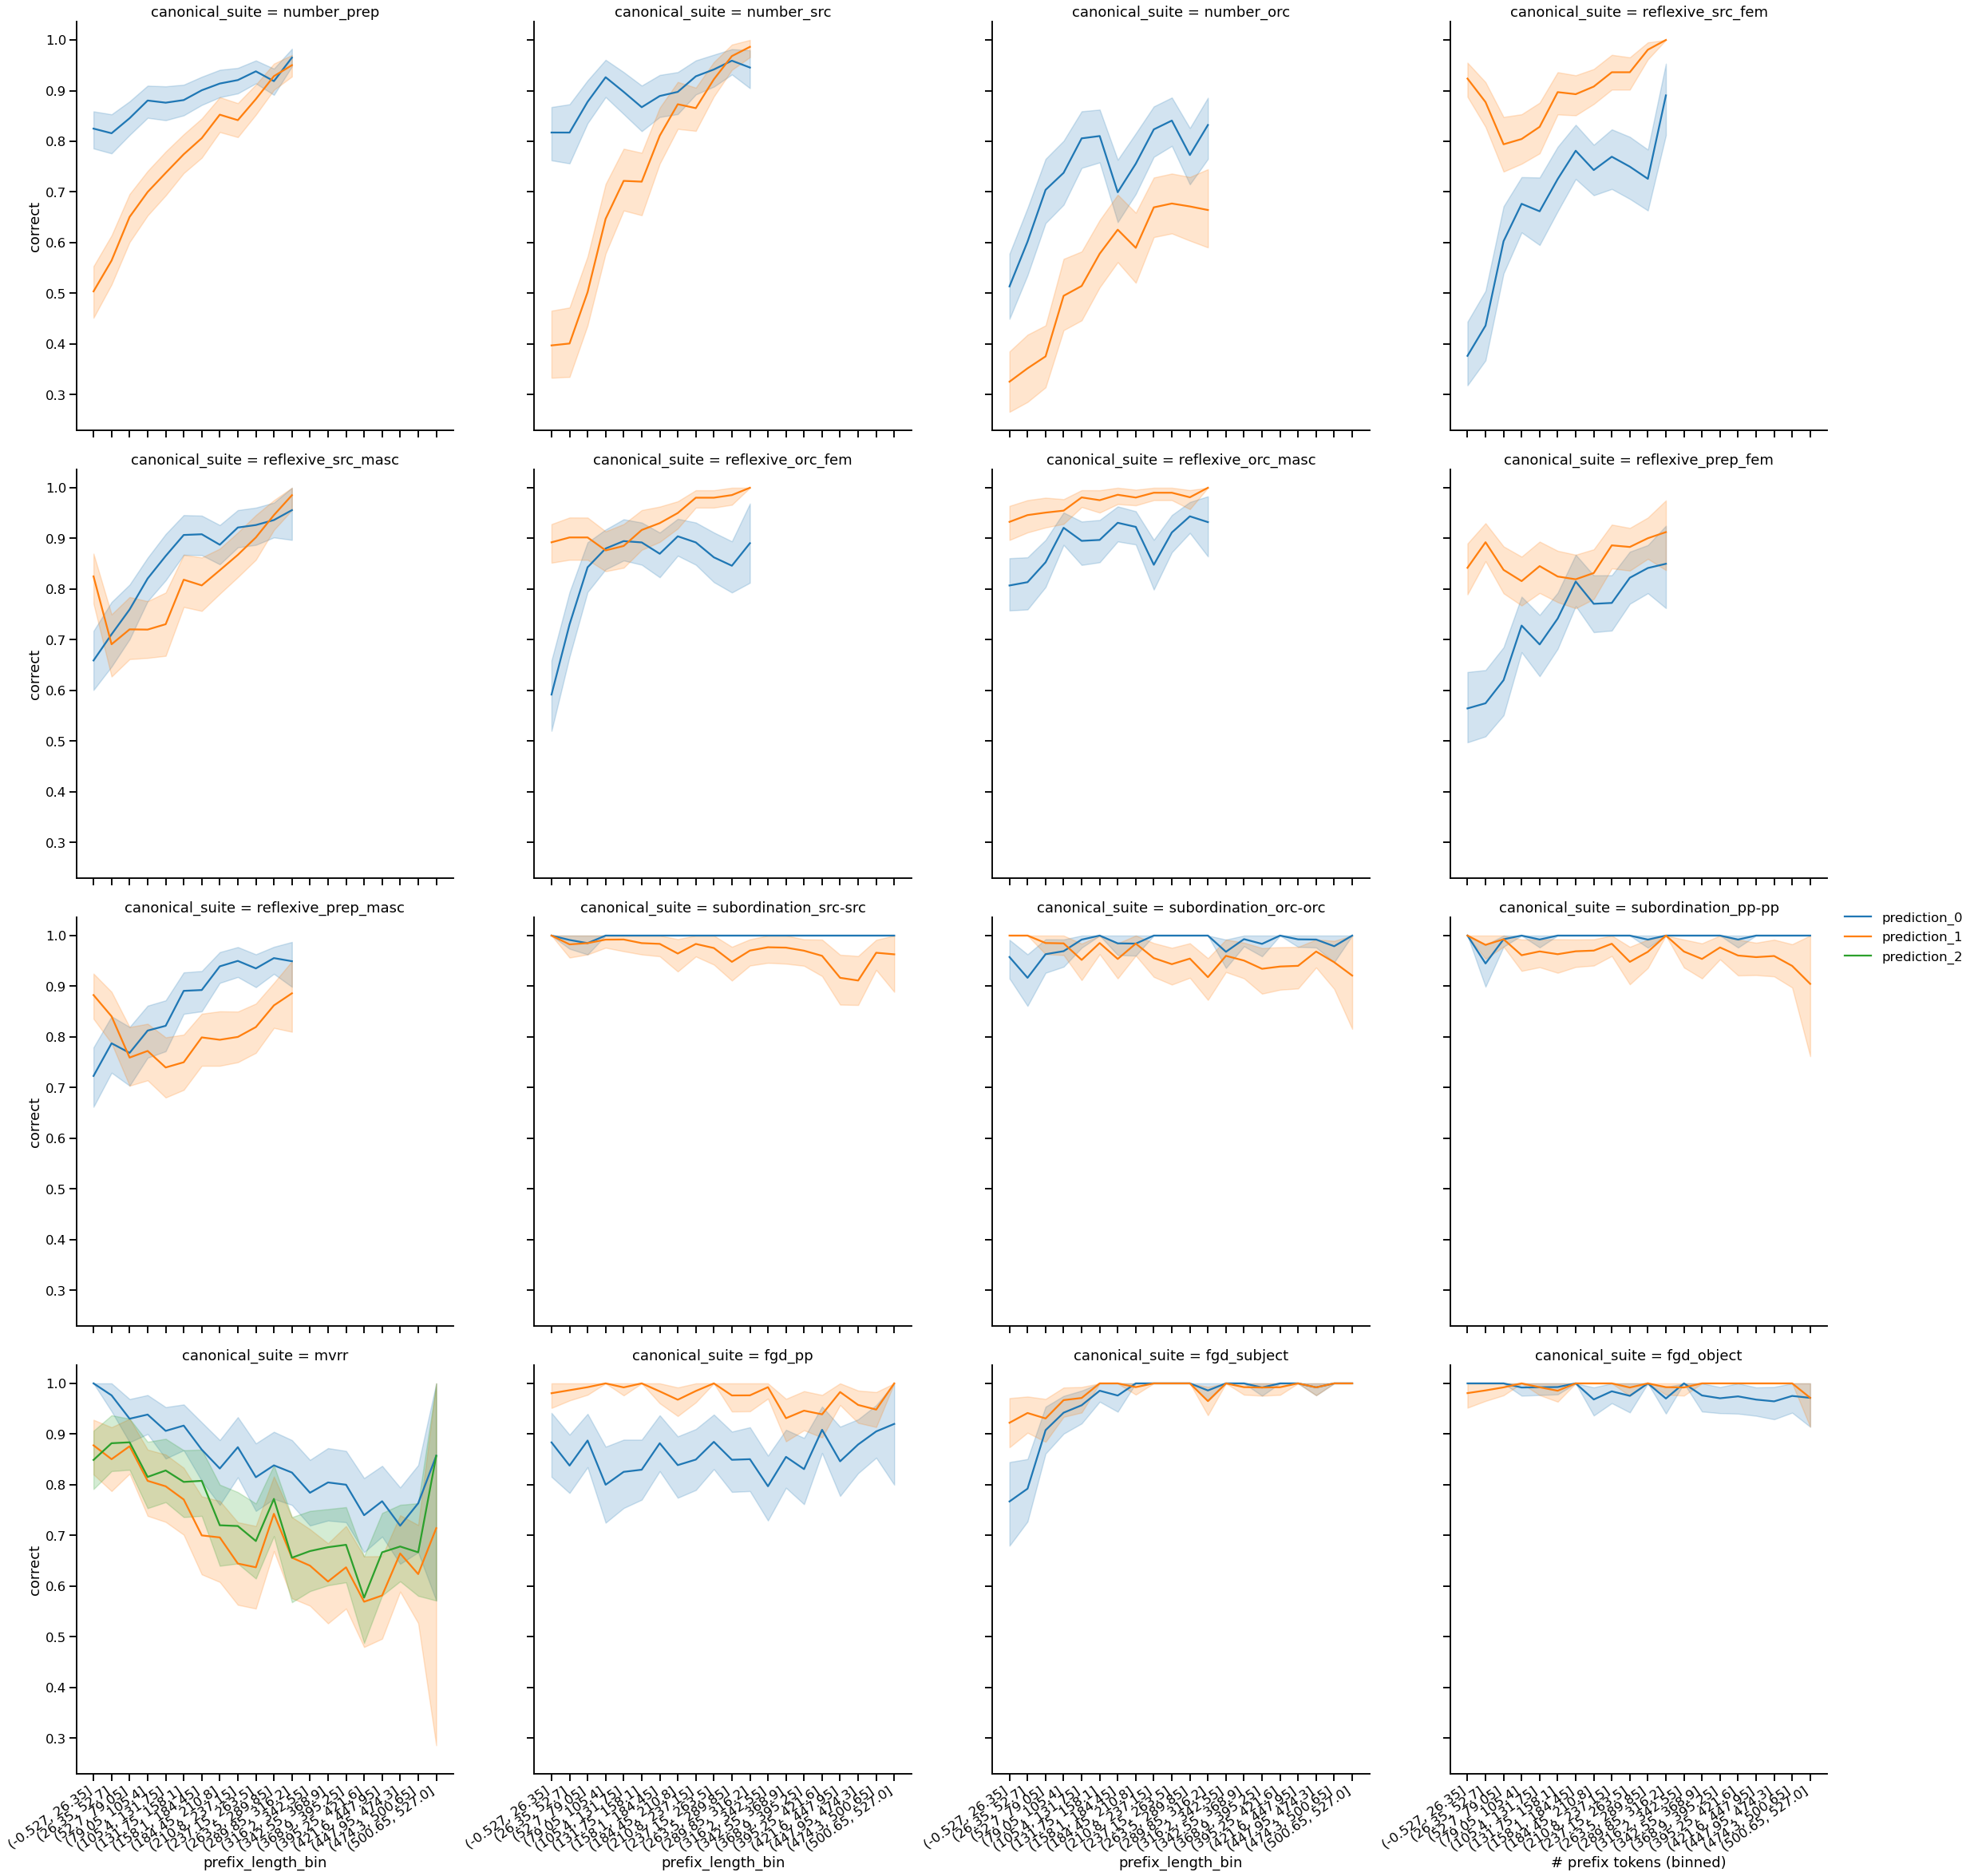

In [13]:
g = sns.FacetGrid(data=prediction_df_melt, height=8, col="canonical_suite", col_wrap=4)
g.map(sns.lineplot, "prefix_length_bin", "correct", "prediction")
g.add_legend()

for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right")

plt.xlabel("# prefix tokens (binned)")
plt.ylabel("Prediction accuracy")

## Margins

In [14]:
region_dfs = [pd.read_csv(f"{suite}.regions.csv") for suite in suites]
region_df = pd.concat(region_dfs, names=["suite"], keys=suites).reset_index()
# Bring in metadata from predictions df
region_df = pd.merge(region_df.reset_index(), prediction_df[meta_vars].reset_index(),
                     on=["suite", "item_number"])

region_df

index        suite  level_1_x  item_number        value  \
0              0  number_prep          0            1    12.441164   
1           4915  number_prep       4915            1    25.171421   
2           9830  number_prep       9830            1     3.329726   
3          14745  number_prep      14745            1    16.262009   
4          19660  number_prep      19660            1     4.061763   
...          ...          ...        ...          ...          ...   
1345045  1335225   fgd_object      73679         2456    19.507397   
1345046  1337681   fgd_object      76135         2456  2279.726074   
1345047  1340137   fgd_object      78591         2456  2279.726074   
1345048  1342593   fgd_object      81047         2456  2279.726074   
1345049  1345049   fgd_object      83503         2456  2279.726074   

          condition  region_number  level_1_y  num_prefix_sentences  \
0        match_sing              3          0                   0.0   
1        match_sing              4          0                   0.0   
2        match_sing              5          0                   0.0   
3        match_sing              6          0                   0.0   
4        match_sing              7          0                   0.0   
...             ...            ...        ...                   ...   
1345045    that_gap              9       2455                  31.0   
1345046  what_nogap              1       2455                  31.0   
1345047  that_nogap              1       2455                  31.0   
1345048    what_gap              1       2455                  31.0   
1345049    that_gap              1       2455                  31.0   

         prefix_length prefix_length_bin canonical_suite suite_category  
0                    0   (-0.527, 26.35]     number_prep         number  
1                    0   (-0.527, 26.35]     number_prep         number  
2                    0   (-0.527, 26.35]     number_prep         number  
3                    0   (-0.527, 26.35]     number_prep         number  
4                    0   (-0.527, 26.35]     number_prep         number  
...                ...               ...             ...            ...  
1345045            494   (474.3, 500.65]      fgd_object            fgd  
1345046            494   (474.3, 500.65]      fgd_object            fgd  
1345047            494   (474.3, 500.65]      fgd_object            fgd  
1345048            494   (474.3, 500.65]      fgd_object            fgd  
1345049            494   (474.3, 500.65]      fgd_object            fgd  

[1345050 rows x 13 columns]

In [15]:
_, df = next(iter(region_df.groupby(["suite"])))
df.region_number.astype(str).str.cat(df.condition, " ").isin(critical_region_strs["mvrr"])

1261546    False
1261547    False
1261548    False
1261549    False
1261550    False
           ...  
1345045    False
1345046    False
1345047    False
1345048    False
1345049    False
Name: region_number, Length: 83504, dtype: bool

In [16]:
def filter_critical_regions(suite_df):
    critical_strs = critical_region_strs[suite_df.canonical_suite.iloc[0]]
    is_critical = suite_df.region_number.astype(str).str.cat(suite_df.condition, " ").isin(critical_strs)
    return suite_df[is_critical]

critical_region_df = region_df.groupby(["suite", "canonical_suite"], as_index=False) \
    .apply(filter_critical_regions)
critical_region_df

index                  suite  level_1_x  item_number      value  \
0  1261550  1271370             fgd_object       9824            1  16.567860   
   1261558  1291018             fgd_object      29472            1  12.456110   
   1261566  1310666             fgd_object      49120            1  10.868265   
   1261573  1327858             fgd_object      66312            1  13.471580   
   1261584  1271371             fgd_object       9825            2  17.799953   
...             ...                    ...        ...          ...        ...   
15 906763    896998  subordination_src-src      48958         2447  11.311989   
   906772    860279  subordination_src-src      12239         2448   6.276355   
   906777    872519  subordination_src-src      24479         2448   4.079598   
   906782    884759  subordination_src-src      36719         2448  29.245785   
   906787    896999  subordination_src-src      48959         2448  36.252571   

                   condition  region_number  level_1_y  num_prefix_sentences  \
0  1261550        what_nogap              6          0                   0.0   
   1261558        that_nogap              6          0                   0.0   
   1261566          what_gap              7          0                   0.0   
   1261573          that_gap              7          0                   0.0   
   1261584        what_nogap              6          1                   0.0   
...                      ...            ...        ...                   ...   
15 906763      no-sub_matrix              6       2446                  24.0   
   906772      sub_no-matrix              6       2447                  24.0   
   906777   no-sub_no-matrix              6       2447                  24.0   
   906782         sub_matrix              6       2447                  24.0   
   906787      no-sub_matrix              6       2447                  24.0   

            prefix_length prefix_length_bin        canonical_suite  \
0  1261550              0   (-0.527, 26.35]             fgd_object   
   1261558              0   (-0.527, 26.35]             fgd_object   
   1261566              0   (-0.527, 26.35]             fgd_object   
   1261573              0   (-0.527, 26.35]             fgd_object   
   1261584              0   (-0.527, 26.35]             fgd_object   
...                   ...               ...                    ...   
15 906763             509   (500.65, 527.0]  subordination_src-src   
   906772             492   (474.3, 500.65]  subordination_src-src   
   906777             492   (474.3, 500.65]  subordination_src-src   
   906782             492   (474.3, 500.65]  subordination_src-src   
   906787             492   (474.3, 500.65]  subordination_src-src   

           suite_category  
0  1261550            fgd  
   1261558            fgd  
   1261566            fgd  
   1261573            fgd  
   1261584            fgd  
...                   ...  
15 906763   subordination  
   906772   subordination  
   906777   subordination  
   906782   subordination  
   906787   subordination  

[164984 rows x 13 columns]

Text(1734.1100000000004, 0.5, 'Raw surprisal')

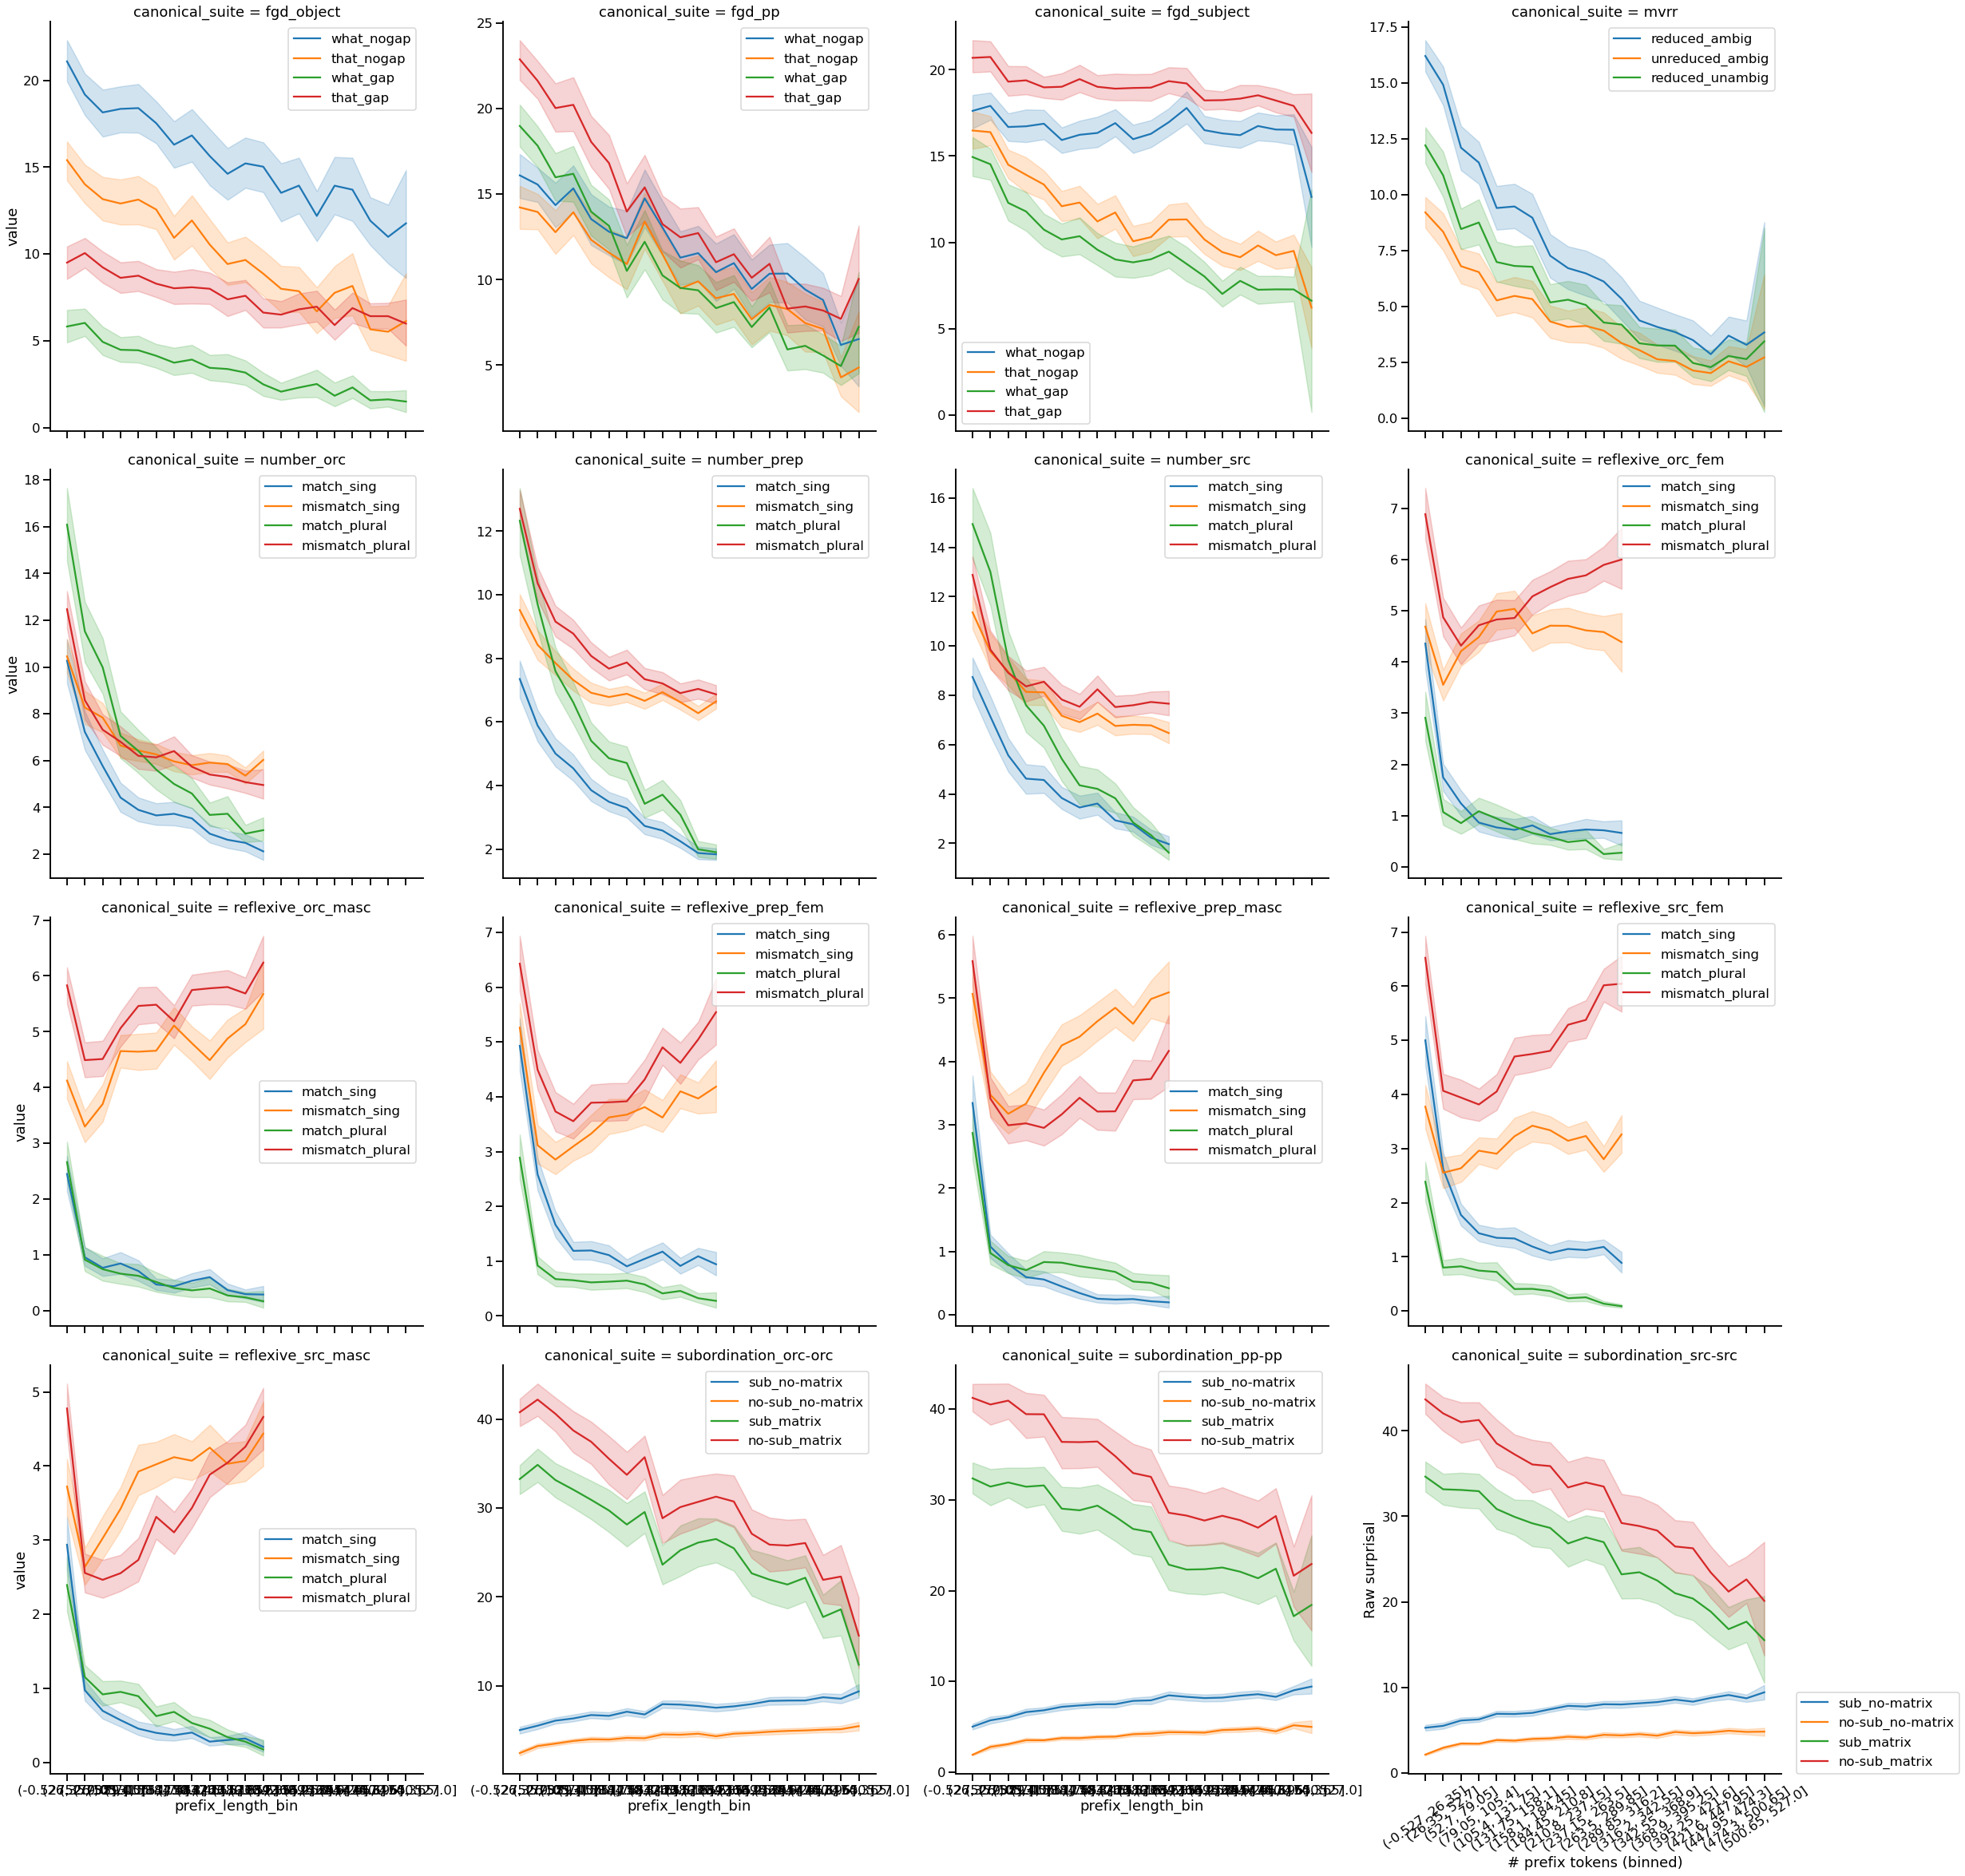

In [17]:
g = sns.FacetGrid(data=critical_region_df, height=8, col="canonical_suite", col_wrap=4, sharey=False)
g.map(sns.lineplot, "prefix_length_bin", "value", "condition")
for ax in g.axes.ravel():
    ax.legend()

plt.xticks(rotation=35)
plt.legend(loc=(1.04,0))
plt.xlabel("# prefix tokens (binned)")
plt.ylabel("Raw surprisal")

In [18]:
# g = sns.catplot(data=critical_region_df, x="num_prefix_sentences", y="value", hue="condition", alpha=0.1,
#                 height=10)
# sns.lineplot(data=critical_region_df, x="num_prefix_sentences", y="value", hue="condition", ax=g.ax, legend=False)

# plt.legend(loc=(1.04,0))
# plt.xlabel("# prefix sentences")
# plt.ylabel("Raw surprisal")

In [19]:
def compute_margins(rows):
    margin_spec = margin_measures[rows.iloc[0].canonical_suite]
    rows = rows.set_index(["region_number", "condition"]).value
    
    margins = pd.Series([rows.loc[ungrammatical] - rows.loc[grammatical]
                         for grammatical, ungrammatical in margin_spec])
    return margins

margin_sizes = critical_region_df.groupby(["suite", "item_number"]).apply(compute_margins)
margin_sizes

0         1
suite                 item_number                    
fgd_object            1            4.111750  2.603314
                      2            5.890624  2.987965
                      3            7.325131  1.937300
                      4            4.117939  3.818717
                      5            4.211559  3.049620
...                                     ...       ...
subordination_src-src 2444         4.818648  1.824209
                      2445         4.321604  6.364243
                      2446         3.327927  6.469498
                      2447         7.665365  4.715309
                      2448         2.196756  7.006786

[41868 rows x 2 columns]

In [20]:
margin_sizes = pd.merge(margin_sizes.reset_index(), prediction_df[meta_vars].reset_index(),
                        on=["suite", "item_number"])
margin_sizes

suite  item_number         0         1  level_1  \
0                 fgd_object            1  4.111750  2.603314        0   
1                 fgd_object            2  5.890624  2.987965        1   
2                 fgd_object            3  7.325131  1.937300        2   
3                 fgd_object            4  4.117939  3.818717        3   
4                 fgd_object            5  4.211559  3.049620        4   
...                      ...          ...       ...       ...      ...   
41863  subordination_src-src         2444  4.818648  1.824209     2443   
41864  subordination_src-src         2445  4.321604  6.364243     2444   
41865  subordination_src-src         2446  3.327927  6.469498     2445   
41866  subordination_src-src         2447  7.665365  4.715309     2446   
41867  subordination_src-src         2448  2.196756  7.006786     2447   

       num_prefix_sentences  prefix_length prefix_length_bin  \
0                       0.0              0   (-0.527, 26.35]   
1                       0.0              0   (-0.527, 26.35]   
2                       0.0              0   (-0.527, 26.35]   
3                       0.0              0   (-0.527, 26.35]   
4                       0.0              0   (-0.527, 26.35]   
...                     ...            ...               ...   
41863                  24.0            509   (500.65, 527.0]   
41864                  24.0            492   (474.3, 500.65]   
41865                  24.0            485   (474.3, 500.65]   
41866                  24.0            509   (500.65, 527.0]   
41867                  24.0            492   (474.3, 500.65]   

             canonical_suite suite_category  
0                 fgd_object            fgd  
1                 fgd_object            fgd  
2                 fgd_object            fgd  
3                 fgd_object            fgd  
4                 fgd_object            fgd  
...                      ...            ...  
41863  subordination_src-src  subordination  
41864  subordination_src-src  subordination  
41865  subordination_src-src  subordination  
41866  subordination_src-src  subordination  
41867  subordination_src-src  subordination  

[41868 rows x 10 columns]

In [21]:
# Prefer binned figure below.

# sns.lineplot(data=margin_sizes.melt(id_vars=["prefix_length"], value_vars=["sing", "plur"], var_name="Prediction"),
#              x="prefix_length", y="value", hue="Prediction")

# plt.legend(loc=(1.04, 0))
# plt.axhline(0, color="gray", linestyle="--")
# plt.xlabel("# prefix tokens")
# plt.ylabel("Grammaticality margin (bits)")

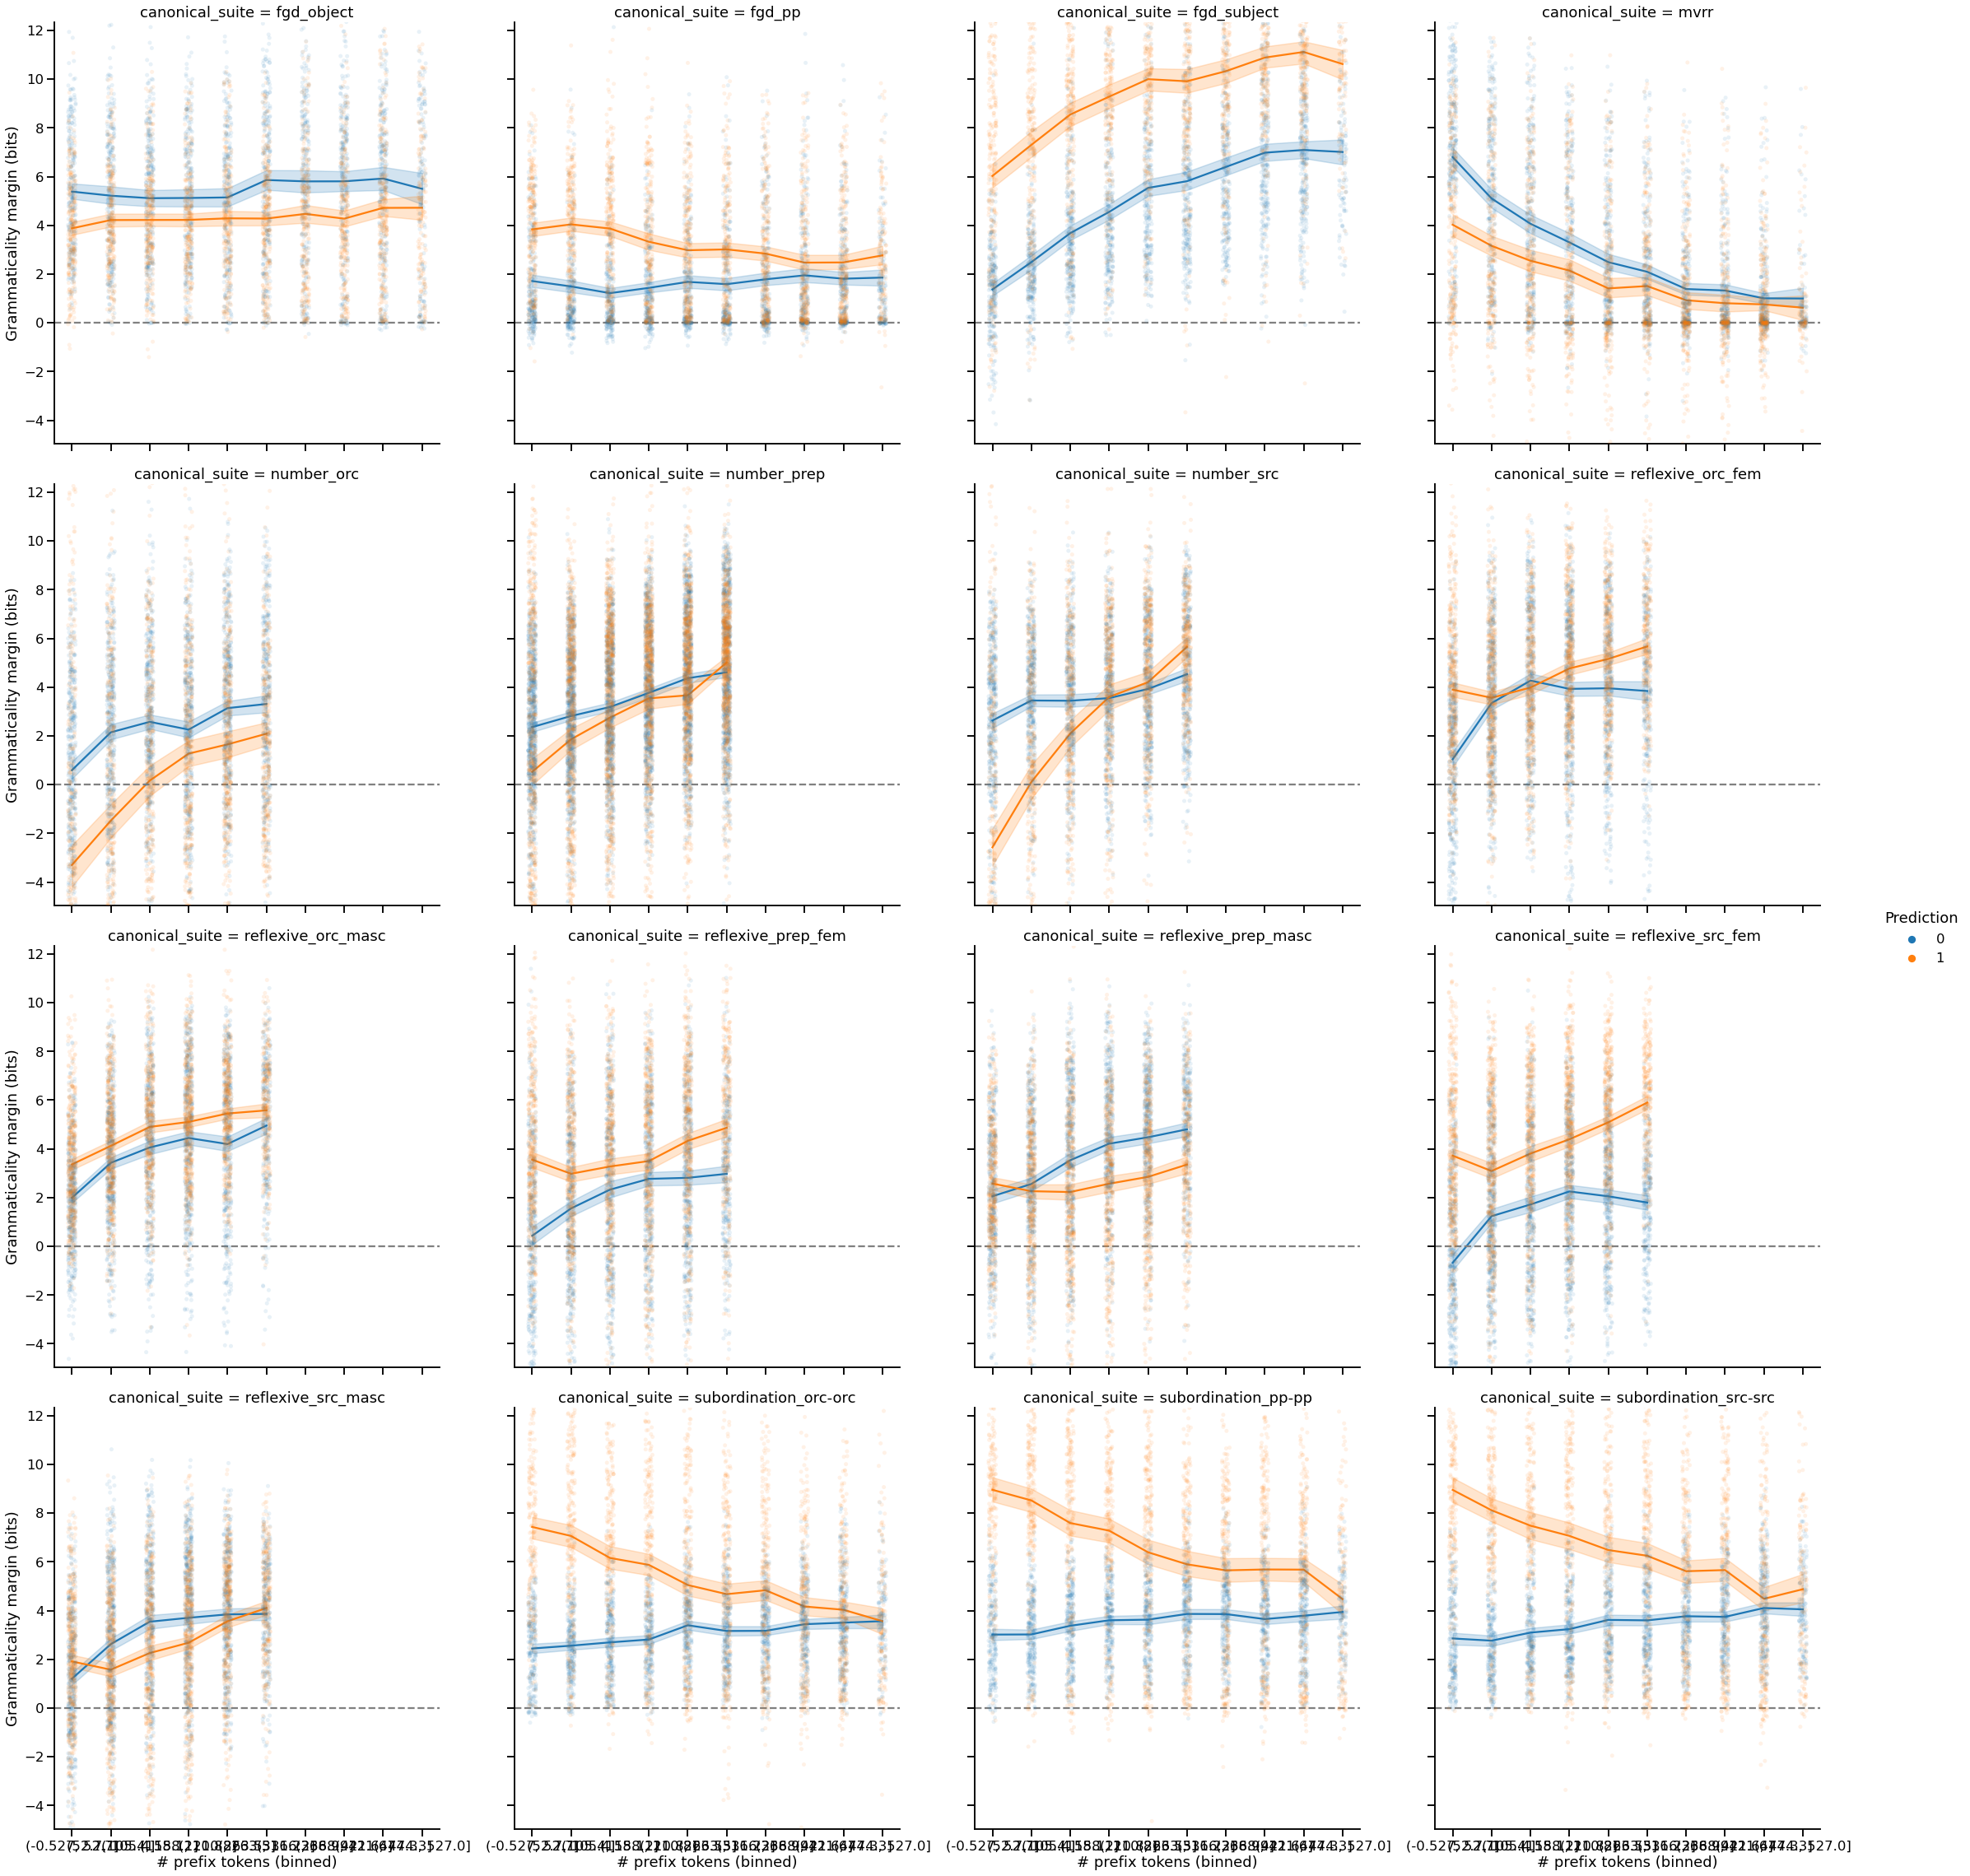

In [22]:
margin_sizes["prefix_length_bin"] = pd.cut(margin_sizes.prefix_length, 10).astype(str)
to_plot = margin_sizes.melt(id_vars=meta_vars,
                            value_vars=[0, 1], var_name="Prediction")
g = sns.catplot(data=to_plot, col="canonical_suite", col_wrap=4,
                x="prefix_length_bin", y="value", hue="Prediction", alpha=0.1, height=8)
g.map(sns.lineplot, "prefix_length_bin", "value", "Prediction")

for ax in g.axes.flat:
    ax.axhline(0, color="gray", linestyle="--")
    ax.set_xticks(ax.get_xticks(), rotation=35)
    ax.set_xlabel("# prefix tokens (binned)")
    ax.set_ylabel("Grammaticality margin (bits)")

In [23]:
# DEV recompute predictions as a sanity check
recompute_preds = margin_sizes.assign(**{f"correct_{idx}": margin_sizes[idx] > 0
                                         for idx in [col for col in margin_sizes.columns if isinstance(col, int)]})

<AxesSubplot:xlabel='prefix_length_bin', ylabel='value'>

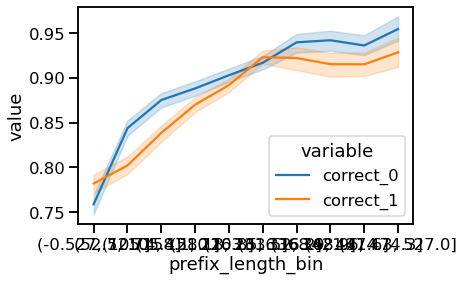

In [24]:
sns.lineplot(data=recompute_preds[["prefix_length_bin", "correct_0", "correct_1"]].melt(id_vars=["prefix_length_bin"]),
             x="prefix_length_bin", y="value", hue="variable")

In [25]:
# recompute_preds[recompute_preds.prefix_length == 0].groupby("canonical_suite").correct.mean()
recompute_preds[recompute_preds.prefix_length == 0][["correct_0", "correct_1"]].melt().groupby("variable").value.mean()

variable
correct_0    0.773529
correct_1    0.870588
Name: value, dtype: float64

## Total probability margins

In [26]:
total_surprisals = region_df.groupby(["suite", "canonical_suite", "item_number", "condition"]).value.sum().reset_index()
total_surprisals

suite        canonical_suite  item_number  \
0                  fgd_object             fgd_object            1   
1                  fgd_object             fgd_object            1   
2                  fgd_object             fgd_object            1   
3                  fgd_object             fgd_object            1   
4                  fgd_object             fgd_object            2   
...                       ...                    ...          ...   
167467  subordination_src-src  subordination_src-src         2447   
167468  subordination_src-src  subordination_src-src         2448   
167469  subordination_src-src  subordination_src-src         2448   
167470  subordination_src-src  subordination_src-src         2448   
167471  subordination_src-src  subordination_src-src         2448   

               condition        value  
0               that_gap    99.497898  
1             that_nogap   103.921446  
2               what_gap   103.183990  
3             what_nogap   116.899148  
4               that_gap    87.429735  
...                  ...          ...  
167467     sub_no-matrix  2413.919429  
167468     no-sub_matrix  2494.311867  
167469  no-sub_no-matrix  2462.138893  
167470        sub_matrix  2496.571949  
167471     sub_no-matrix  2473.602521  

[167472 rows x 5 columns]

In [27]:
def compute_margins(rows):
    margin_spec = margin_measures[rows.iloc[0].canonical_suite]
    rows = rows.set_index(["condition"]).value
    return pd.Series([rows.loc[ungrammatical_cond] - rows.loc[grammatical_cond]
                      for (_, grammatical_cond), (_, ungrammatical_cond) in margin_spec])

total_surprisal_margins = total_surprisals.groupby(["suite", "item_number"]).apply(compute_margins)
total_surprisal_margins

0         1
suite                 item_number                     
fgd_object            1            12.977702 -3.686091
                      2            13.686185 -5.734768
                      3            19.124560 -7.625071
                      4             8.526286 -0.400149
                      5            15.895537 -5.632507
...                                      ...       ...
subordination_src-src 2444          8.835566 -2.192711
                      2445         12.073153 -1.387066
                      2446          7.068299  2.728880
                      2447          8.012713  4.367473
                      2448         11.463628 -2.260082

[41868 rows x 2 columns]

In [28]:
# Bring back metadata
total_surprisal_margins = pd.merge(total_surprisal_margins.reset_index(), prediction_df[meta_vars].reset_index(),
                                   on=["suite", "item_number"])

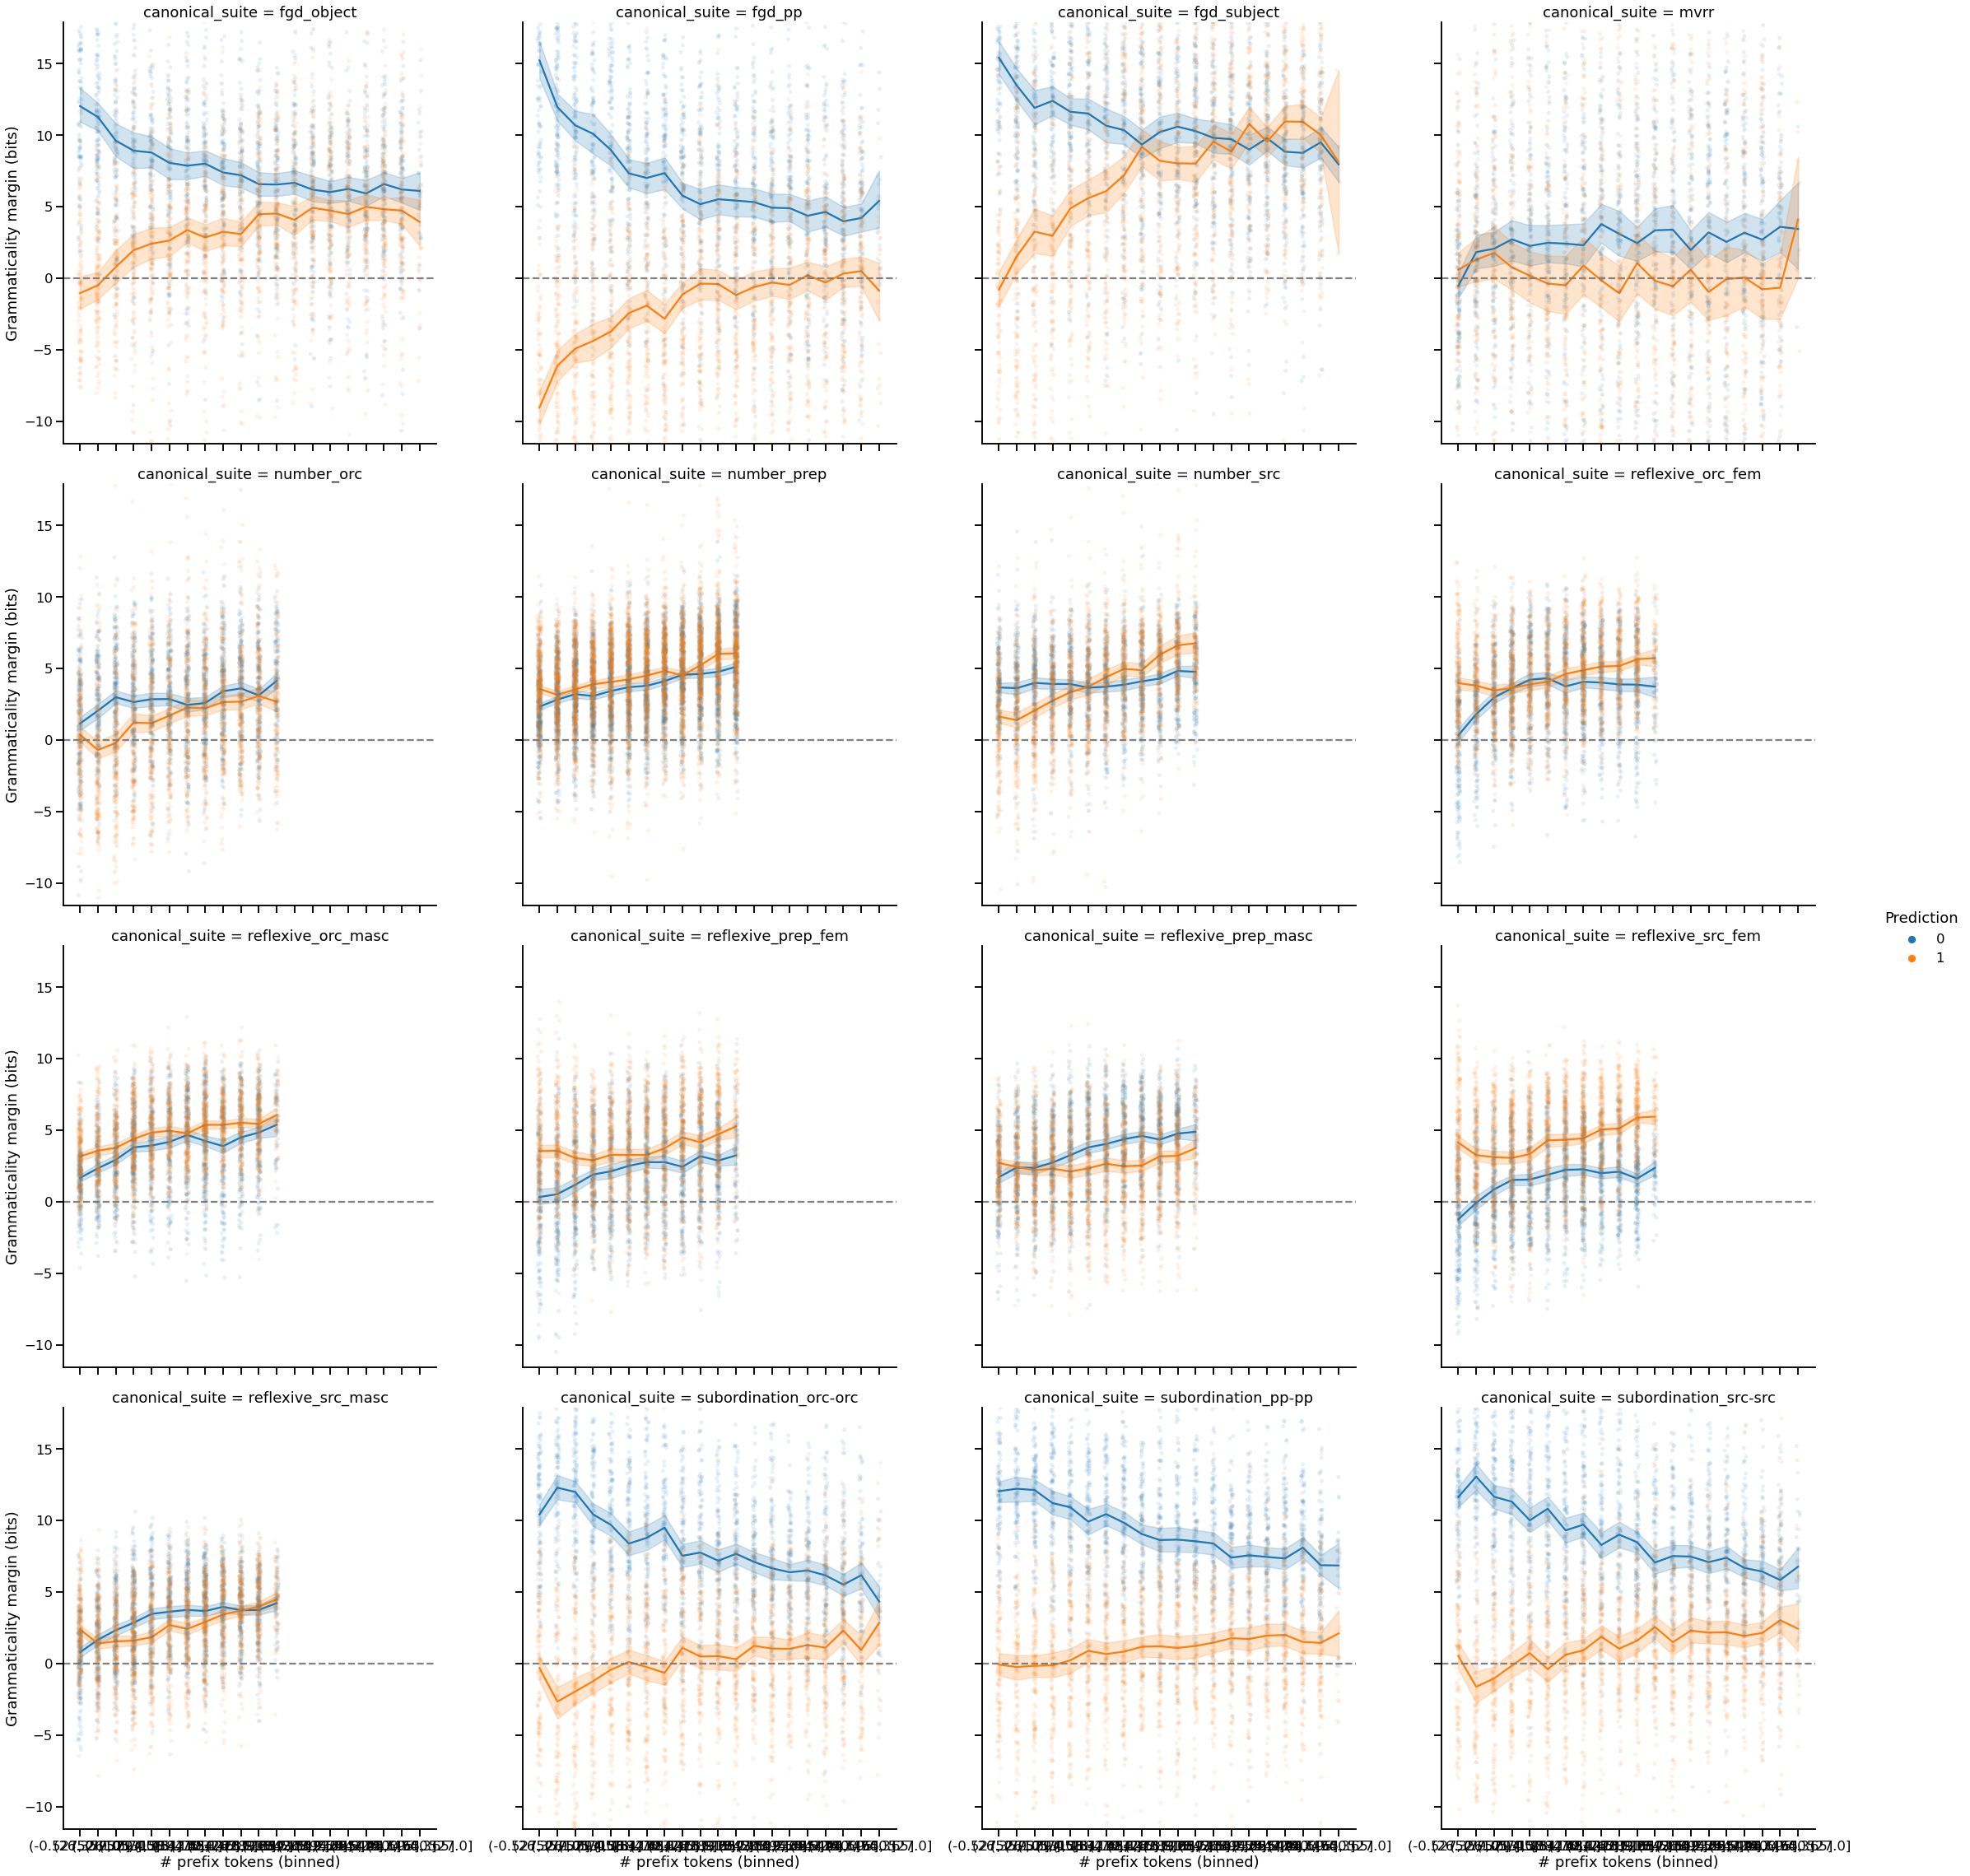

In [29]:
to_plot = total_surprisal_margins.melt(id_vars=["prefix_length_bin", "canonical_suite"],
                                       value_vars=[0, 1], var_name="Prediction")
g = sns.catplot(data=to_plot, col="canonical_suite", col_wrap=4,
                x="prefix_length_bin", y="value", hue="Prediction", alpha=0.1, height=8)
g.map(sns.lineplot, "prefix_length_bin", "value", "Prediction")

for ax in g.axes.flat:
    ax.axhline(0, color="gray", linestyle="--")
    ax.set_xticks(ax.get_xticks(), rotation=35)
    ax.set_xlabel("# prefix tokens (binned)")
    ax.set_ylabel("Grammaticality margin (bits)")